In [6]:

import dgl
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import networkx as nx
import numpy as np
import pandas as pd
import random
import seaborn as sns
from time import time
import torch
import warnings
import yfinance as yf

from utils import build_nx_graph, gen_q_dict_mis, gen_q_dict_mis_handcrafted, qubo_dict_to_torch, \
    get_gnn, run_gnn_training, loss_func, postprocess_gnn_mis, run_mis_solver
from utils_backtest import portfolio_return, sharpe_ratio, sortino_ratio, \
    max_drawdown, calmar_ratio
from utils_backtest import max_drawdown_series, annualized_sharpe_ratio, annualized_sortino_ratio, \
    annualized_max_drawdown, annualized_calmar_ratio
from utils_distance_correlation import df_distance_correlation

warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

In [7]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


In [8]:
RISK_FREE_RATE = 0.01

## Read in Data

In [9]:
sp500_hist = pd.read_csv(
    "./data/sp500_hist_prices.csv",
    parse_dates=['Date'],
    index_col='Date'
)

sp500_hist = sp500_hist.loc['2014-01-01':,]
sp500_hist.dropna(axis=1, inplace=True)


print(f'Shape: {sp500_hist.shape}')
sp500_hist.head()

Shape: (2266, 470)


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,37.141602,23.907921,101.185295,17.388981,35.240082,60.504734,31.847378,19.123333,68.658348,59.290001,...,169.137527,20.609207,66.582367,44.643036,30.301586,45.261662,83.170258,53.180000,24.822664,30.329689
2014-01-03,37.610752,25.020359,104.080498,17.007023,35.457024,60.548027,32.188923,18.756666,68.886833,59.160000,...,167.479828,20.601709,66.422142,44.857124,30.576576,45.544949,83.530914,53.580002,24.998468,30.039131
2014-01-06,37.425739,25.482304,103.084709,17.099760,34.162140,60.331593,32.613773,18.580000,68.159042,58.119999,...,167.360214,20.489336,66.522278,44.587177,30.523350,45.508789,84.071892,53.400002,24.822664,29.973518
2014-01-07,37.960957,25.369169,104.357124,16.977465,34.229923,60.989532,32.363853,18.586666,68.988396,58.970001,...,172.188049,20.841444,67.463448,45.276005,30.612062,46.147724,85.749016,53.950001,24.898008,30.085989
2014-01-08,38.582062,26.047947,103.545738,17.084980,34.141792,61.586887,32.655426,18.476667,69.521561,58.900002,...,175.417999,20.759035,67.243179,45.359783,30.594316,46.129646,87.849907,53.910000,25.115677,29.748577


### S&P500 as Benchmark

In [10]:
gspc = yf.download(
    tickers="^GSPC", 
    start=sp500_hist.index[0].strftime(format="%Y-%m-%d"), 
    end=sp500_hist.index[-1].strftime(format="%Y-%m-%d")
)['Adj Close']

gspc

[*********************100%***********************]  1 of 1 completed


Date
2014-01-02    1831.979980
2014-01-03    1831.369995
2014-01-06    1826.770020
2014-01-07    1837.880005
2014-01-08    1837.489990
                 ...     
2022-12-22    3822.389893
2022-12-23    3844.820068
2022-12-27    3829.250000
2022-12-28    3783.219971
2022-12-29    3849.280029
Name: Adj Close, Length: 2265, dtype: float64

In [11]:
TRAIN_START_DATE, TRAIN_END_DATE = "2014-01-01", "2019-01-01"
VAL_START_DATE, VAL_END_DATE = TRAIN_END_DATE, "2021-01-01"
TEST_START_DATE, TEST_END_DATE = VAL_END_DATE, "2022-12-30"

df_train = sp500_hist.loc[TRAIN_START_DATE:TRAIN_END_DATE,:]
df_val = sp500_hist.loc[VAL_START_DATE:VAL_END_DATE,:]
df_test = sp500_hist.loc[TEST_START_DATE:TEST_END_DATE,:]

gspc_train = gspc.loc[TRAIN_START_DATE:TRAIN_END_DATE]
gspc_val = gspc.loc[VAL_START_DATE:VAL_END_DATE]
gspc_test = gspc.loc[TEST_START_DATE:TEST_END_DATE]

print(f"Train shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")

assert df_train.shape[1] == df_val.shape[1] and df_val.shape[1] == df_test.shape[1]
assert df_train.shape[0] == gspc_train.shape[0] 
assert df_val.shape[0] == gspc_val.shape[0]
assert df_test.shape[0] == gspc_test.shape[0] + 1


Train shape: (1258, 470)
Validation shape: (505, 470)
Test shape: (503, 470)


# Visualize

In [12]:
df_train_pct = df_train.pct_change()
df_train_cum = (df_train_pct + 1).cumprod() -1
df_train_cum.iloc[-1,:].sort_values(ascending=False)[:10].index

Index(['NVDA', 'TTWO', 'AVGO', 'NFLX', 'AMD', 'EW', 'CNC', 'ADBE', 'DPZ',
       'ISRG'],
      dtype='object')

In [13]:
sp500_top_weighted = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'TSLA']

In [14]:
# plt.figure(figsize=(16, 8))
# df_train_pct = df_train.pct_change()
# df_train_cum = (df_train_pct + 1).cumprod() -1

# # all stocks
# for stock in df_train_pct.columns:
#     plt.plot(df_train_cum.loc[:,stock], c='C0', alpha=0.5)

# # best performing stocks
# for stock in df_train_cum.iloc[-1,:].sort_values(ascending=False)[:10].index:
#     plt.plot(df_train_cum.loc[:,stock], c='C1', alpha=0.5)

# for stock in sp500_top_weighted:
#     plt.plot(df_train_cum.loc[:,stock], c='C2', alpha=0.5)

# # average
# plt.plot(df_train_cum.mean(axis=1), c='r')
# plt.yscale('symlog')
# plt.show()

### Build correlation matrix

In [15]:
df_train_pct = df_train.pct_change()
df_train_pct = df_train_pct.iloc[1:]
assert df_train_pct.isnull().any

In [16]:
# Pearson correlation
df_corr_pearson = df_train_pct.corr(method='pearson').abs()

print(f"Median Correlation Value: {df_corr_pearson.quantile(0.5).mean():.4f}")
df_corr_pearson.head()

Median Correlation Value: 0.2980


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.382742,0.219645,0.414948,0.421869,0.304739,0.574249,0.331965,0.549816,0.514034,...,0.322726,0.129615,0.393839,0.379775,0.527850,0.403163,0.461232,0.398479,0.446531,0.459521
AAL,0.382742,1.000000,0.225041,0.266363,0.248515,0.261891,0.354514,0.300311,0.342551,0.341944,...,0.229990,0.050026,0.180990,0.276014,0.340913,0.279464,0.287089,0.279151,0.358160,0.299588
AAP,0.219645,0.225041,1.000000,0.164521,0.207446,0.187494,0.272270,0.166838,0.248961,0.201158,...,0.110759,0.138697,0.213190,0.185469,0.251198,0.242426,0.224925,0.216907,0.287356,0.201817
AAPL,0.414948,0.266363,0.164521,1.000000,0.249677,0.210316,0.404470,0.252869,0.434179,0.445038,...,0.240328,0.103077,0.322874,0.275392,0.336190,0.329327,0.348979,0.337855,0.311279,0.346728
ABBV,0.421869,0.248515,0.207446,0.249677,1.000000,0.360658,0.466849,0.192885,0.342592,0.332743,...,0.225820,0.134010,0.305388,0.330411,0.339783,0.254616,0.401070,0.245127,0.300406,0.411759


In [17]:
# Distance correlation
df_corr_dcor = df_distance_correlation(
    df_train=df_train_pct, 
    stocks=df_train_pct.columns.to_list())
df_corr_dcor.to_csv('./data/correlation_matrix_dcor.csv')

print(f"Median Correlation Value: {df_corr_dcor.quantile(0.5).mean():.4f}")
df_corr_dcor.head()

  9%|▊         | 41/470 [00:21<03:44,  1.91it/s]


SystemError: CPUDispatcher(<function _generate_distance_covariance_sqr_terms_avl_impl.<locals>._distance_covariance_sqr_terms_avl_impl at 0x000001B0A0196AF0>) returned a result with an error set

In [ ]:
# Handcrafted correlation matrix
# Daily returns
df_train_pct = df_train.pct_change()
df_corr_daily = df_train_pct.corr(method='pearson').abs()

# Weekly returns
df_train_weekly = df_train.groupby(pd.Grouper(freq='W')).mean()
df_train_weekly_pct = df_train_weekly.pct_change()
df_corr_weekly = df_train_weekly_pct.corr(method='pearson').abs()

# Monthly returns
df_train_monthly = df_train.groupby(pd.Grouper(freq='M')).mean()
df_train_monthly_pct = df_train_monthly.pct_change()
df_corr_monthly = df_train_monthly_pct.corr(method='pearson').abs()

# Drawdowns
df_train_mdd = max_drawdown_series(df_train_pct)
df_corr_mdd = df_train_mdd.corr(method='pearson').abs()

# Final correlation matrix
df_corr_handcrafted = (df_corr_daily + df_corr_weekly + df_corr_monthly + df_corr_mdd) / 4

print(f"Median Correlation Value: {df_corr_handcrafted.quantile(0.5).mean():.4f}")
df_corr_handcrafted.head()

Median Correlation Value: 0.2949


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.336415,0.112084,0.337090,0.519634,0.281384,0.451448,0.377165,0.527892,0.514629,...,0.290921,0.130527,0.326334,0.462165,0.557499,0.413207,0.440721,0.277636,0.385368,0.465099
AAL,0.336415,1.000000,0.224585,0.316611,0.327094,0.411774,0.382326,0.346961,0.354359,0.330613,...,0.283981,0.056149,0.196715,0.330646,0.381744,0.260611,0.248531,0.393732,0.379928,0.327069
AAP,0.112084,0.224585,1.000000,0.127907,0.158994,0.348961,0.178493,0.264507,0.212617,0.120386,...,0.073605,0.154601,0.223060,0.146595,0.160150,0.156150,0.232983,0.203068,0.248211,0.145181
AAPL,0.337090,0.316611,0.127907,1.000000,0.281596,0.338619,0.476821,0.261328,0.422061,0.492672,...,0.322667,0.075339,0.274718,0.184853,0.333161,0.351802,0.342972,0.454407,0.380041,0.476767
ABBV,0.519634,0.327094,0.158994,0.281596,1.000000,0.330901,0.412517,0.306034,0.402962,0.387297,...,0.221236,0.144552,0.228977,0.483205,0.425286,0.203042,0.428325,0.206566,0.376341,0.411124


In [ ]:
STOCK_NAMES = df_corr_pearson.columns.values

## Build Graph

In [ ]:
THRESHOLD = 0.5

# pearson correlation graph
print("Building 'Pearson Correlation' graph...")
nx_graph_pearson = build_nx_graph(
    df_corr=df_corr_pearson,
    threshold=THRESHOLD
)
assert (df_corr_pearson.where(df_corr_pearson >= THRESHOLD).count().sum() - len(df_corr_pearson)) / 2 == len(nx_graph_pearson.edges)

# distance correlation graph
print("Building 'Distance Correlation' graph...")
nx_graph_dcor = build_nx_graph(
    df_corr=df_corr_dcor,
    threshold=THRESHOLD
)
assert (df_corr_dcor.where(df_corr_dcor >= THRESHOLD).count().sum() - len(df_corr_dcor)) / 2 == len(nx_graph_dcor.edges)

# handcrafted correlation graph
print("Building 'Handcrafted Correlation' graph...")
nx_graph_handcrafted = build_nx_graph(
    df_corr=df_corr_handcrafted,
    threshold=THRESHOLD
)
assert (df_corr_handcrafted.where(df_corr_handcrafted >= THRESHOLD).count().sum() - len(df_corr_handcrafted)) / 2 == len(nx_graph_handcrafted.edges)

Building 'Pearson Correlation' graph...
Building 'Distance Correlation' graph...
Building 'Handcrafted Correlation' graph...


In [ ]:
print(f"#Edges Pearson Correlation Graph: {len(nx_graph_pearson.edges)}")
print(f"#Edges Distnace Correlation Graph: {len(nx_graph_dcor.edges)}")
print(f"#Edges Handcrafted Correlation Graph: {len(nx_graph_handcrafted.edges)}")


#Edges Pearson Correlation Graph: 5406
#Edges Distnace Correlation Graph: 4897
#Edges Handcrafted Correlation Graph: 8439


### Plot degree distribution

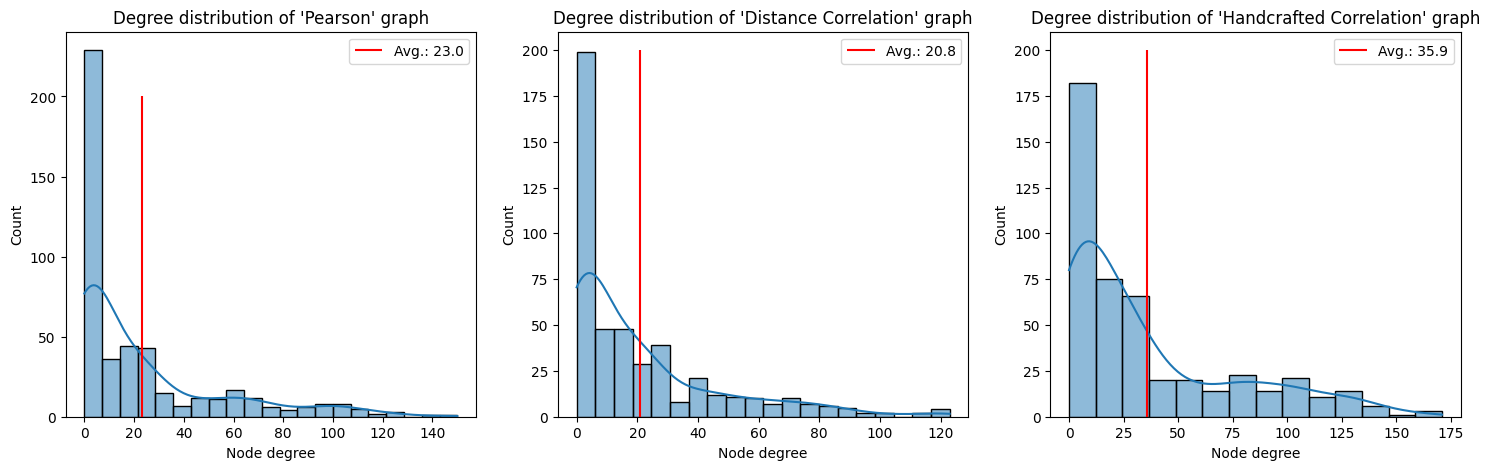

In [ ]:
def plot_degree_distr(graph:nx.Graph, ax:plt.Axes, title:str) -> None:
    """ Plots the degree distribution of a graph."""
    degrees = [degree for (_, degree) in graph.degree()]
    avg_degree = sum(degrees) / len(degrees)

    sns.histplot(degrees, kde=True, ax=ax)
    ax.vlines(avg_degree, ymin=0, ymax=200, colors=['r'], label=f"Avg.: {avg_degree:.1f}")
    ax.set_title(title)
    ax.set_xlabel("Node degree")
    ax.legend()
    # plt.show()

_, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Pearson correlation graph
plot_degree_distr(
    graph=nx_graph_pearson, 
    ax=ax0, 
    title="Degree distribution of 'Pearson' graph")

# Distance correlation graph
plot_degree_distr(
    graph=nx_graph_dcor, 
    ax=ax1, 
    title="Degree distribution of 'Distance Correlation' graph")

# Distance correlation graph
plot_degree_distr(
    graph=nx_graph_handcrafted, 
    ax=ax2, 
    title="Degree distribution of 'Handcrafted Correlation' graph")

plt.show()



### Build Q matrix

In [ ]:
rewards = annualized_sortino_ratio(df_returns=df_train_pct, risk_free_rate=RISK_FREE_RATE, name='Sortino').mean().sort_values(ascending=False)[:20]
rewards

UNH     2.452845
KDP     2.395455
NVDA    2.341463
CTAS    2.118100
BA      2.093751
AMZN    2.075167
MSCI    2.054536
TTWO    2.049412
NOC     1.994726
PGR     1.985087
AVGO    1.898055
NEE     1.859483
CBOE    1.857517
CME     1.846475
NVR     1.838816
ELV     1.832607
EW      1.824803
RSG     1.817087
MSFT    1.804192
ORLY    1.803581
dtype: float64

In [ ]:
# Pearson graph
graph_dgl_pearson = dgl.from_networkx(nx_graph=nx_graph_pearson)
graph_dgl = graph_dgl_pearson.to(TORCH_DEVICE)

q_torch_pearson = qubo_dict_to_torch(
    nx_G=nx_graph_pearson, 
    Q=gen_q_dict_mis(nx_G=nx_graph_pearson, penalty=2), 
    torch_dtype=TORCH_DTYPE, 
    torch_device=TORCH_DEVICE)

# Distance correlation graph
graph_dgl_dcor = dgl.from_networkx(nx_graph=nx_graph_dcor)
graph_dgl_dcor = graph_dgl_dcor.to(TORCH_DEVICE)

q_torch_dcor = qubo_dict_to_torch(
    nx_G=nx_graph_dcor, 
    Q=gen_q_dict_mis(nx_G=nx_graph_dcor, penalty=3), 
    torch_dtype=TORCH_DTYPE, 
    torch_device=TORCH_DEVICE)

# Handcrafted correlation graph
graph_dgl_handcrafted = dgl.from_networkx(nx_graph=nx_graph_handcrafted)
graph_dgl_handcrafted = graph_dgl_handcrafted.to(TORCH_DEVICE)

rewards = annualized_sortino_ratio(
    df_returns=df_train_pct,
    risk_free_rate=RISK_FREE_RATE, 
    name='Sortino'
    ).mean() * -1

q_torch_handcrafted = qubo_dict_to_torch(
    nx_G=nx_graph_handcrafted, 
    Q=gen_q_dict_mis_handcrafted(nx_G=nx_graph_handcrafted, rewards=rewards, penalty=3), 
    torch_dtype=TORCH_DTYPE, 
    torch_device=TORCH_DEVICE)

In [ ]:
q_torch_pearson

tensor([[-1.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0., -1.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0., -1.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ..., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0., -1.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0., -1.]])

In [ ]:
q_torch_handcrafted

tensor([[-1.0973,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.6336,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -1.0543,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -1.2131,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.3982,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -1.5804]])

### Visualize graph

Plotting pearson graph...
Plotting distance correlation graph...
Plotting handcrafted correlation graph...


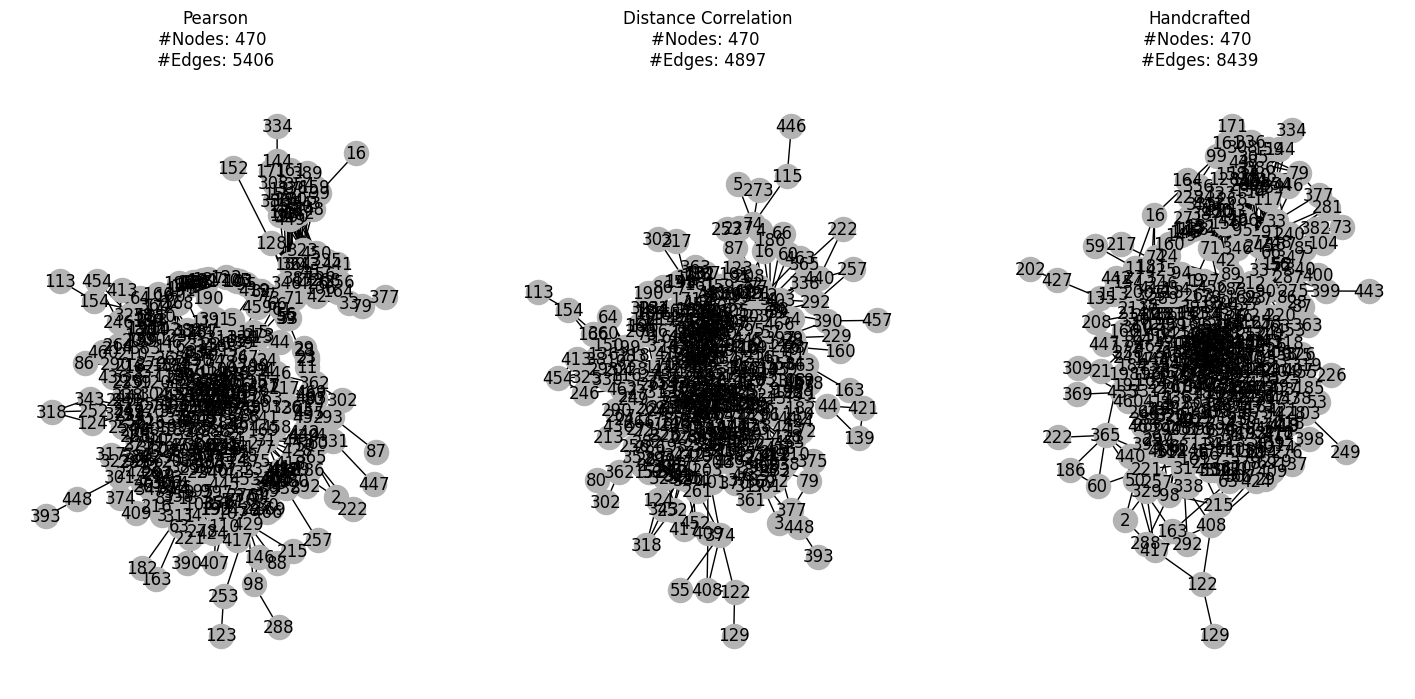

In [ ]:
_, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

print("Plotting pearson graph...")
pos_pearson = nx.kamada_kawai_layout(nx_graph_pearson)
ax0.set_title(f"Pearson\n#Nodes: {nx_graph_pearson.number_of_nodes()} \n" \
              f"#Edges: {nx_graph_pearson.number_of_edges()}")
nx.draw(nx_graph_pearson, pos_pearson, with_labels=True, node_color=[[.7, .7, .7]], ax=ax0)

print("Plotting distance correlation graph...")
pos_dcor = nx.kamada_kawai_layout(nx_graph_dcor)
ax1.set_title(f"Distance Correlation\n#Nodes: {nx_graph_dcor.number_of_nodes()} \n" \
              f"#Edges: {nx_graph_dcor.number_of_edges()}")
nx.draw(nx_graph_dcor, pos_dcor, with_labels=True, node_color=[[.7, .7, .7]], ax=ax1)

print("Plotting handcrafted correlation graph...")
pos_handrafted = nx.kamada_kawai_layout(nx_graph_handcrafted)
ax2.set_title(f"Handcrafted\n#Nodes: {nx_graph_handcrafted.number_of_nodes()} \n" \
              f"#Edges: {nx_graph_handcrafted.number_of_edges()}")
nx.draw(nx_graph_handcrafted, pos_handrafted, with_labels=True, node_color=[[.7, .7, .7]], ax=ax2)

## Set up GNN

In [ ]:
# best set of parameters according to 
# hyperparameter tuning

params = {'lr': 0.0001,
 'dim_embedding': 22,
 'hidden_dim': 11,
 'dropout': 0.05,
 'number_classes': 1,
 'prob_threshold': 0.5,
 'number_epochs': 16_000,
 'tolerance': 0.0001,
 'patience': 1000,
 'model': 'SAGE_2L_Model'}

In [ ]:
assert nx_graph_pearson.number_of_nodes() == nx_graph_dcor.number_of_nodes()
assert nx_graph_dcor.number_of_nodes() == nx_graph_handcrafted.number_of_nodes()
assert nx_graph_pearson.number_of_nodes() == nx_graph_handcrafted.number_of_nodes()

n = nx_graph_pearson.number_of_nodes()

net, embed, optimizer = get_gnn(
    n_nodes=n,
    params=params, 
    model_type='SAGE_2L_Model', 
    torch_device=TORCH_DEVICE, 
    torch_dtype=TORCH_DTYPE
)

net

SAGE_2L_Model(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=22, out_features=22, bias=True)
    (fc_neigh): Linear(in_features=22, out_features=11, bias=False)
    (fc_self): Linear(in_features=22, out_features=11, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=11, out_features=11, bias=True)
    (fc_neigh): Linear(in_features=11, out_features=1, bias=False)
    (fc_self): Linear(in_features=11, out_features=1, bias=True)
  )
)

## Run GNN training

In [ ]:
training_inputs = [
    ('pearson', graph_dgl_pearson, q_torch_pearson, nx_graph_pearson),
    ('dcor', graph_dgl_dcor, q_torch_dcor, nx_graph_dcor),
    ('handcrafted', graph_dgl_handcrafted, q_torch_handcrafted, nx_graph_handcrafted)]
training_results = {}

for (name, dgl_graph, q_torch, nx_graph) in training_inputs:
    print(f"\nRunning GNN training for {name} graph...")

    gnn_start = time()
    
    net, embed, optimizer = get_gnn(
        n_nodes=n,
        params=params, 
        model_type='SAGE_2L_Model', 
        torch_device=TORCH_DEVICE, 
        torch_dtype=TORCH_DTYPE
    )
    
    net, epoch, final_bitstring, best_bitstring, best_loss, inputs, loss_hist, epoch_hist = run_gnn_training(
        q_torch=q_torch, 
        dgl_graph=dgl_graph, 
        net=net, 
        embed=embed, 
        optimizer=optimizer, 
        number_epochs=params['number_epochs']+1,
        tol=params['tolerance'], 
        patience=params['patience'], 
        prob_threshold=params['prob_threshold']
    )
    
    gnn_runtime = time() - gnn_start
    
    training_results[name] = {}
    training_results[name]['net'] = net
    training_results[name]['epoch'] = epoch
    training_results[name]['final_bitstring'] = final_bitstring
    training_results[name]['best_bitstring'] = best_bitstring
    training_results[name]['best_loss'] = best_loss.item()
    training_results[name]['loss_hist'] = loss_hist
    training_results[name]['epoch_hist'] = epoch_hist
    training_results[name]['gnn_runtime'] = gnn_runtime

    print(f"Graph post-processing...")
    final_loss = loss_func(final_bitstring.float(), q_torch)
    final_bitstring_str = ','.join([str(x) for x in final_bitstring])

    # Process bitstring reported by GNN
    size_mis_gnn, ind_set_gnn, number_violations_gnn = postprocess_gnn_mis(best_bitstring, nx_graph)

    training_results[name]['final_loss'] = final_loss.item()
    training_results[name]['size_mis_gnn'] = size_mis_gnn.item()
    training_results[name]['ind_set_gnn'] = ind_set_gnn
    training_results[name]['number_violations_gnn'] = number_violations_gnn




Running GNN training for pearson graph...
Epoch: 0, Loss: -36.27659606933594
Epoch: 1000, Loss: -106.58497619628906
Epoch: 2000, Loss: -147.20973205566406
Epoch: 3000, Loss: -159.8602294921875
Epoch: 4000, Loss: -160.8619842529297
Epoch: 5000, Loss: -160.26199340820312
Epoch: 6000, Loss: -173.16888427734375
Epoch: 7000, Loss: -162.17977905273438
Epoch: 8000, Loss: -184.45069885253906
Epoch: 9000, Loss: -191.0403289794922
Epoch: 10000, Loss: -194.35806274414062
Epoch: 11000, Loss: -194.52989196777344
Epoch: 12000, Loss: -195.7673797607422
Epoch: 13000, Loss: -195.72732543945312
Epoch: 14000, Loss: -195.9052734375
Epoch: 15000, Loss: -195.91395568847656
Epoch: 16000, Loss: -195.87525939941406
GNN training (n=470) took 109.734
GNN final continuous loss: -195.87525939941406
GNN best continuous loss: -195.99057006835938
Graph post-processing...
Calculating violations...

Running GNN training for dcor graph...
Epoch: 0, Loss: 14233.7412109375
Epoch: 1000, Loss: -63.24155044555664
Epoch: 200

## Post-process GNN Results

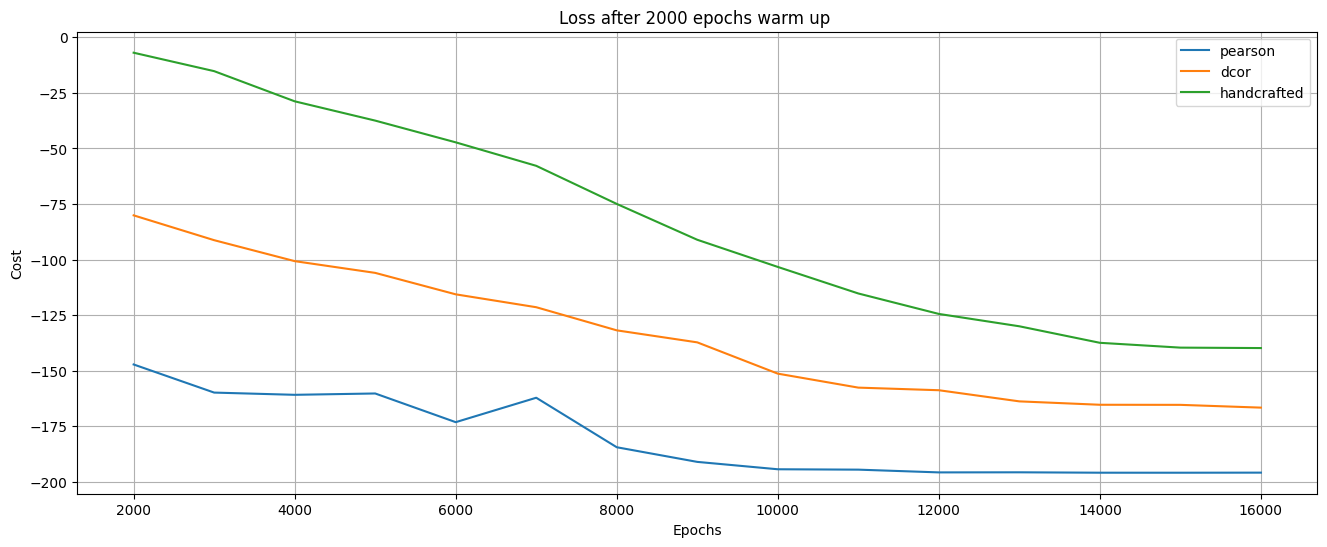

In [ ]:
_, (ax0) = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

name = 'pearson'
tr_res_dict = training_results[name]
ax0.plot(tr_res_dict['epoch_hist'][2:], tr_res_dict['loss_hist'][2:] , label=name)

name = 'dcor'
tr_res_dict = training_results[name]
ax0.plot(tr_res_dict['epoch_hist'][2:], tr_res_dict['loss_hist'][2:] , label=name)

name = 'handcrafted'
tr_res_dict = training_results[name]
ax0.plot(tr_res_dict['epoch_hist'][2:], tr_res_dict['loss_hist'][2:] , label=name)

ax0.set_title("Loss after 2000 epochs warm up ")
ax0.set_ylabel("Cost")
ax0.set_xlabel("Epochs")
plt.grid()
plt.legend()
plt.show()

In [ ]:
s = f"""
Pearson:
--------
    MIS size:       {training_results['pearson']['size_mis_gnn']}
    Violations:     {training_results['pearson']['number_violations_gnn']}
    Runtime (s):    {training_results['pearson']['gnn_runtime']:.1f}

Distance Correlation:
--------
    MIS size:       {training_results['dcor']['size_mis_gnn']}
    Violations:     {training_results['dcor']['number_violations_gnn']}
    Runtime (s):    {training_results['dcor']['gnn_runtime']:.1f}

Handcrafted:
--------
    MIS size:       {training_results['handcrafted']['size_mis_gnn']}
    Violations:     {training_results['handcrafted']['number_violations_gnn']}
    Runtime (s):    {training_results['handcrafted']['gnn_runtime']:.1f}
"""

print(s)


Pearson:
--------
    MIS size:       196
    Violations:     0
    Runtime (s):    109.7

Distance Correlation:
--------
    MIS size:       168
    Violations:     0
    Runtime (s):    109.6

Handcrafted:
--------
    MIS size:       139
    Violations:     0
    Runtime (s):    111.2



Plotting pearson graph...
Plotting dcor graph...
Plotting handcrafted graph...


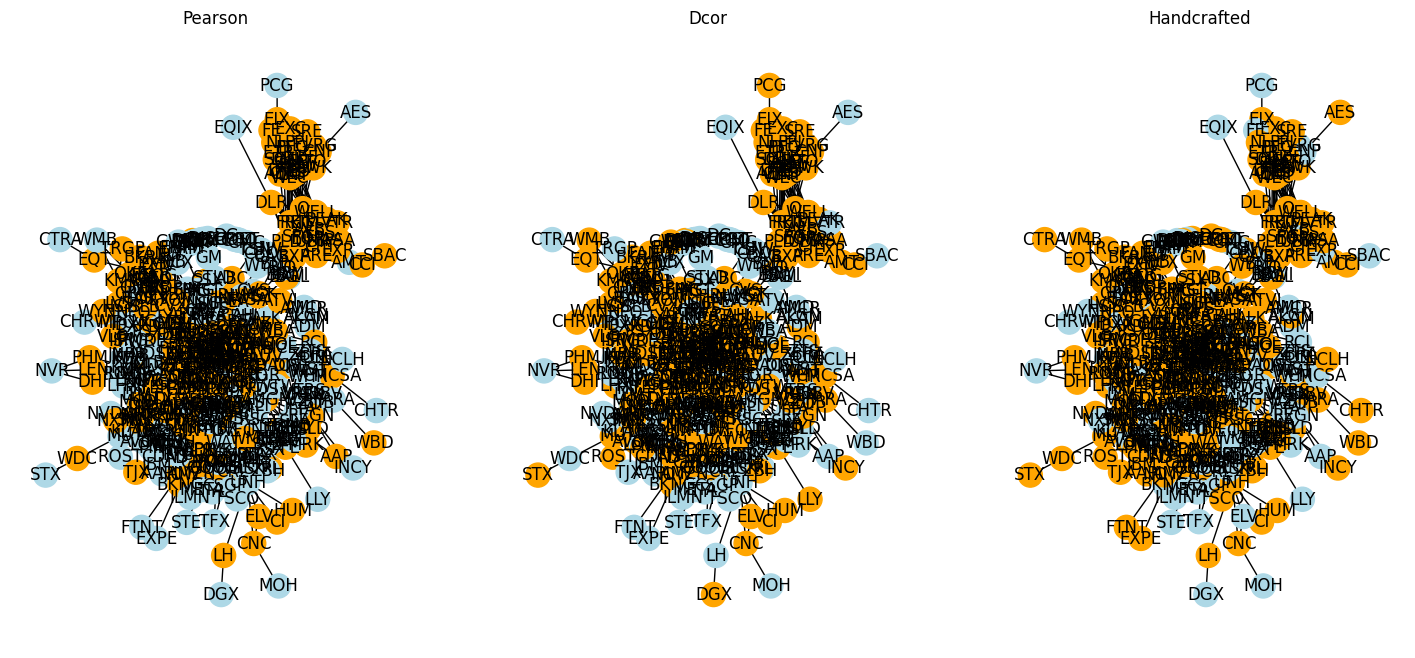

In [ ]:
_, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

# Pearson
name = 'pearson'
ax = ax0
print(f"Plotting {name} graph...")
best_bitstring = training_results[name]['best_bitstring']
gnn_mis_set_pearson = STOCK_NAMES[np.argwhere(best_bitstring == 1)].tolist()[0]

color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph_pearson.nodes]
nx_graph_labelled = nx.relabel_nodes(nx_graph_pearson, lambda x: STOCK_NAMES[x])
pos_labelled = nx.kamada_kawai_layout(nx_graph_labelled)

ax.set_title(f"{name.capitalize()}")
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax)

# Distance Correlation
name = 'dcor'
ax = ax1
print(f"Plotting {name} graph...")
best_bitstring = training_results[name]['best_bitstring']
gnn_mis_set_dcor = STOCK_NAMES[np.argwhere(best_bitstring == 1)].tolist()[0]

color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph_pearson.nodes]
nx_graph_labelled = nx.relabel_nodes(nx_graph_pearson, lambda x: STOCK_NAMES[x])
pos_labelled = nx.kamada_kawai_layout(nx_graph_labelled)

ax.set_title(f"{name.capitalize()}")
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax)

# Handcrafted
name = 'handcrafted'
ax = ax2
print(f"Plotting {name} graph...")
best_bitstring = training_results[name]['best_bitstring']
gnn_mis_set_handcrafted = STOCK_NAMES[np.argwhere(best_bitstring == 1)].tolist()[0]

color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph_pearson.nodes]
nx_graph_labelled = nx.relabel_nodes(nx_graph_pearson, lambda x: STOCK_NAMES[x])
pos_labelled = nx.kamada_kawai_layout(nx_graph_labelled)

ax.set_title(f"{name.capitalize()}")
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax)

plt.show()

In [ ]:
n_intersec = len(set(gnn_mis_set_pearson) & set(gnn_mis_set_dcor) & set(gnn_mis_set_handcrafted))
s = f"""
Size of Intersection:               {n_intersec}

Size Independent Set    | % of Intersction
------------------------------------------
Pearson:        {len(gnn_mis_set_pearson)}     |  {(n_intersec / len(gnn_mis_set_pearson) * 100):.1f} %
Dist. corr.:    {len(gnn_mis_set_dcor)}     |  {(n_intersec / len(gnn_mis_set_dcor) * 100):.1f} %
Hhandcrafted:   {len(gnn_mis_set_handcrafted)}     |  {(n_intersec / len(gnn_mis_set_handcrafted) * 100):.1f} %
"""
print(s)


Size of Intersection:               80

Size Independent Set    | % of Intersction
------------------------------------------
Pearson:        196     |  40.8 %
Dist. corr.:    168     |  47.6 %
Hhandcrafted:   139     |  57.6 %



## Compare against traditional solver

In [ ]:
# run solver
print(f'Running built-in MIS solver (n={n}).')
start = time()
ind_set_bitstring_nx, ind_set_nx_size, number_violations_nx, t_solve = run_mis_solver(nx_graph_pearson)
end = time()
runtime_sol = end - start
print(f'Independence number found by nx solver is {ind_set_nx_size} with {number_violations_nx} violations.')
print(f'MIS solver took {round(runtime_sol, 3)}s')

Running built-in MIS solver (n=470).
Calculating violations...
Independence number found by nx solver is 194 with 0 violations.
MIS solver took 12.204s


In [ ]:
solver_mis_set = STOCK_NAMES[np.argwhere(torch.tensor(ind_set_bitstring_nx) == 1)].tolist()[0]

Plotting pearson graph...


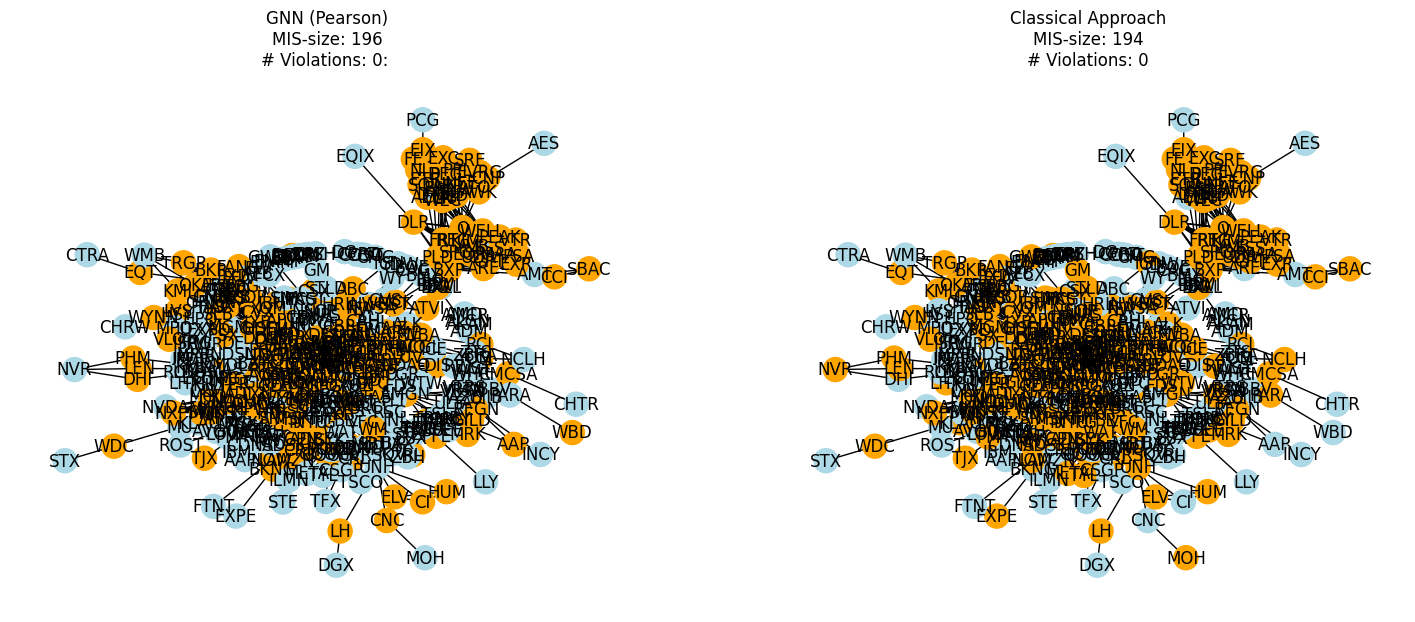

In [ ]:
_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

# Pearson
name = 'pearson'
ax = ax0
print(f"Plotting {name} graph...")
best_bitstring = training_results[name]['best_bitstring']
size_mis_gnn = training_results[name]['size_mis_gnn']
number_violations_gnn = training_results[name]['number_violations_gnn']

color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph_pearson.nodes]
nx_graph_labelled = nx.relabel_nodes(nx_graph_pearson, lambda x: STOCK_NAMES[x])
pos_labelled = nx.kamada_kawai_layout(nx_graph_labelled)

ax.set_title(f"GNN (Pearson)\nMIS-size: {size_mis_gnn}\n# Violations: {number_violations_gnn}: ")
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax)

# MIS algo (classic approach)
color_map = ['orange' if (ind_set_bitstring_nx[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax1)
ax1.set_title(f"Classical Approach\nMIS-size: {ind_set_nx_size}\n# Violations: {number_violations_nx}")
plt.show()

## Backtest

In [ ]:
def drawdown_pct(return_series):
    rs_max = return_series.rolling(
        window=len(return_series), 
        min_periods=1
        ).max()
    return return_series - rs_max

### Training

# stocks in pearson portfolio: 196
# stocks in dist. corr. portfolio: 168
# stocks in handcrafted portfolio: 139
# stocks in solver portfolio: 194


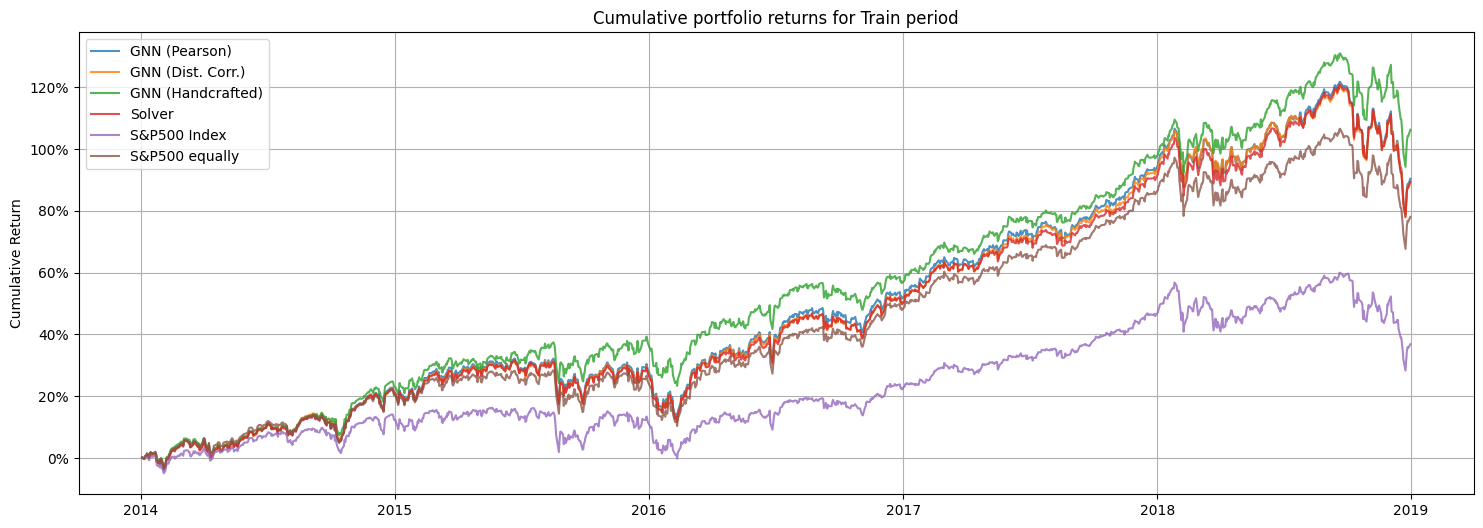

In [ ]:
# GNN Pearson Portfolio
print(f"# stocks in pearson portfolio: {len(gnn_mis_set_pearson)}")
gnn_mis_pearson_returns_train, gnn_mis_pearson_returns_cum_train = portfolio_return(
    df=df_train,
    assets=gnn_mis_set_pearson
)

# GNN DCOR Portfolio
print(f"# stocks in dist. corr. portfolio: {len(gnn_mis_set_dcor)}")
gnn_mis_dcor_returns_train, gnn_mis_dcor_returns_cum_train = portfolio_return(
    df=df_train,
    assets=gnn_mis_set_dcor
)

# GNN Handcrafted Portfolio
print(f"# stocks in handcrafted portfolio: {len(gnn_mis_set_handcrafted)}")
gnn_mis_handcrafted_returns_train, gnn_mis_handcrafted_returns_cum_train = portfolio_return(
    df=df_train,
    assets=gnn_mis_set_handcrafted
)

# Solver MIS Portfolio
print(f"# stocks in solver portfolio: {len(solver_mis_set)}")
solver_mis_returns_train, solver_mis_returns_cum_train = portfolio_return(
    df=df_train,
    assets=solver_mis_set
)

# Benchmark S&P500
gspc_returns_train = gspc_train.pct_change()
gspc_returns_cum_train = (gspc_returns_train + 1).cumprod() -1
# gspc_returns_cumsum_train = gspc_returns_train.cumsum()

# Benchmark all assets equally
gspc_equal_returns_train, gspc_equal_returns_cum_train = portfolio_return(
    df=df_train,
    assets=df_train.columns.to_list()
)

# # Not in GNN MIS Portfolio
# ni_gnn_mis_set = list(set(df_train.columns.to_list()) - set(gnn_mis_set))
# not_gnn_mis_returns_train, not_gnn_mis_returns_cum_train = portfolio_return(
#     df=df_train,
#     assets=ni_gnn_mis_set
# )

# Plot
_, ax = plt.subplots(figsize=(18,6))
alpha_value = 0.8

ax.plot(gnn_mis_pearson_returns_cum_train, label="GNN (Pearson)", alpha=alpha_value)
ax.plot(gnn_mis_dcor_returns_cum_train, label="GNN (DCOR)", alpha=alpha_value)
ax.plot(gnn_mis_handcrafted_returns_cum_train, label="GNN (Handcrafted)", alpha=alpha_value)
ax.plot(solver_mis_returns_cum_train, label="Solver", alpha=alpha_value)

ax.plot(gspc_returns_cum_train, label="S&P500 Index", alpha=alpha_value)
ax.plot(gspc_equal_returns_cum_train, label="S&P500 equally", alpha=alpha_value)

ax.set_title("Cumulative portfolio returns for Train period")
ax.set_ylabel("Cumulative Return")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.legend()
ax.grid()
plt.show()

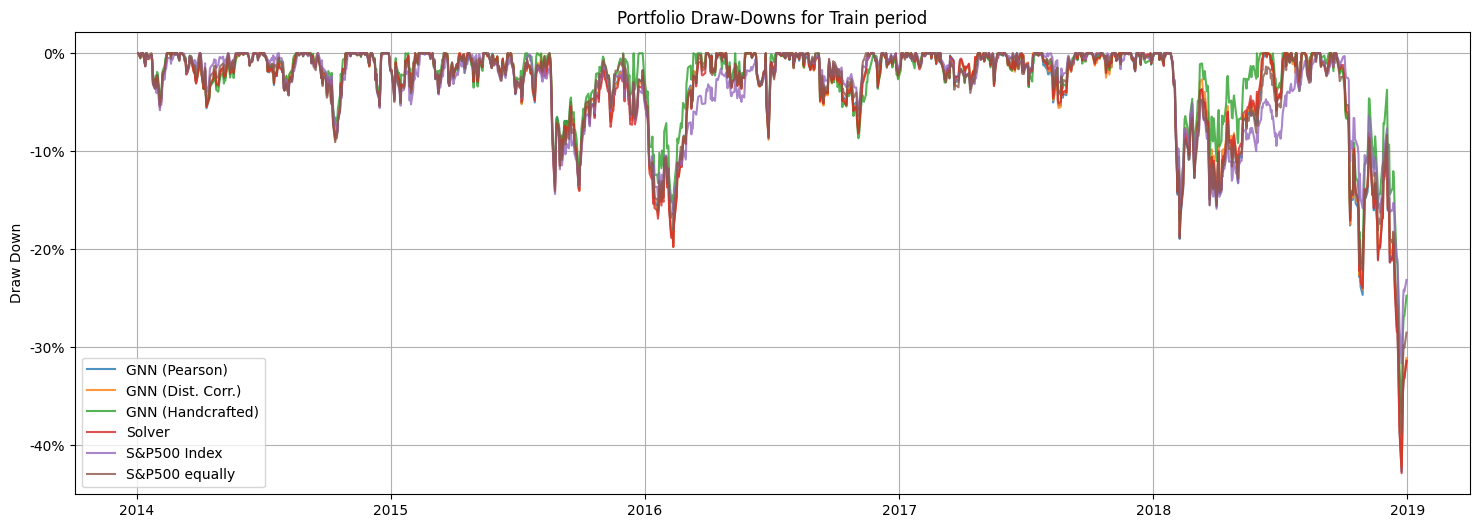

In [ ]:
gnn_mis_pearson_mdd_train = drawdown_pct(gnn_mis_pearson_returns_cum_train)
gnn_mis_dcor_mdd_train = drawdown_pct(gnn_mis_dcor_returns_cum_train)
gnn_mis_handcrafted_mdd_train = drawdown_pct(gnn_mis_handcrafted_returns_cum_train)
solver_mis_mdd_train = drawdown_pct(solver_mis_returns_cum_train)

gspc_mdd_train = drawdown_pct(gspc_returns_cum_train)
gspc_equal_mdd_train = drawdown_pct(gspc_equal_returns_cum_train)


# Plot
alpha_value = 0.8
_, ax = plt.subplots(figsize=(18,6))

ax.plot(gnn_mis_pearson_mdd_train, label="GNN (Pearson)", alpha=alpha_value)
ax.plot(gnn_mis_dcor_mdd_train, label="GNN (DCOR)", alpha=alpha_value)
ax.plot(gnn_mis_handcrafted_mdd_train, label="GNN (Handcrafted)", alpha=alpha_value)
ax.plot(solver_mis_mdd_train, label="Solver", alpha=alpha_value)

ax.plot(gspc_mdd_train, label="S&P500 Index", alpha=alpha_value)
ax.plot(gspc_equal_mdd_train, label="S&P500 equally", alpha=alpha_value)

ax.set_title("Portfolio Draw-Downs for Train period")
ax.set_ylabel("Draw Down")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.legend()
ax.grid()
plt.show()

In [ ]:
# Sharpe Ratios
df_sharpe_train = pd.concat([
    annualized_sharpe_ratio(df_returns=gnn_mis_pearson_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_dcor_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (DCOR)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_handcrafted_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_sharpe_ratio(df_returns=solver_mis_returns_train, risk_free_rate=RISK_FREE_RATE, name='Solver'),
    annualized_sharpe_ratio(df_returns=gspc_returns_train, risk_free_rate=RISK_FREE_RATE, name='S&P500 Index'),
    annualized_sharpe_ratio(df_returns=gspc_equal_returns_train, risk_free_rate=RISK_FREE_RATE, name='S&P500 equally')
], axis=1).T

df_sharpe_train['Avg'] = df_sharpe_train.mean(axis=1)
df_sharpe_train.columns.rename('', inplace=True)
multi_idx = np.array([['Sharpe']*len(df_sharpe_train.index), df_sharpe_train.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sharpe_train.index = multi_idx
df_sharpe_train.round(2)

2014  2015  2016  2017  2018   Avg
Metric Portfolio                                            
Sharpe GNN (Pearson)      1.56  0.39  1.13  3.07 -0.06  1.22
       GNN (Dist. Corr.)  1.55  0.37  1.10  3.16 -0.06  1.22
       GNN (Handcrafted)  1.76  0.75  0.99  3.17  0.31  1.40
       Solver             1.53  0.36  1.11  3.06  0.00  1.21
       S&P500 Index       1.00 -0.03  0.68  2.54 -0.35  0.77
       S&P500 equally     1.53  0.24  1.18  3.06 -0.24  1.15

In [ ]:
# Sortino Ratios
df_sortino_train = pd.concat([
    annualized_sortino_ratio(df_returns=gnn_mis_pearson_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    annualized_sortino_ratio(df_returns=gnn_mis_dcor_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (DCOR)'),
    annualized_sortino_ratio(df_returns=gnn_mis_handcrafted_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_sortino_ratio(df_returns=solver_mis_returns_train, risk_free_rate=RISK_FREE_RATE, name='Solver'),
    annualized_sortino_ratio(df_returns=gspc_returns_train, risk_free_rate=RISK_FREE_RATE, name='S&P500 Index'),
    annualized_sortino_ratio(df_returns=gspc_equal_returns_train, risk_free_rate=RISK_FREE_RATE, name='S&P500 Equal'),

], axis=1).T

df_sortino_train['Avg'] = df_sortino_train.mean(axis=1)
df_sortino_train.columns.rename('', inplace=True)
multi_idx = np.array([['Sortino']*len(df_sortino_train.index), df_sortino_train.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sortino_train.index = multi_idx
df_sortino_train.round(2)

2014  2015  2016  2017  2018   Avg
Metric  Portfolio                                            
Sortino GNN (Pearson)      2.04  0.56  1.48  4.44 -0.07  1.69
        GNN (Dist. Corr.)  2.03  0.52  1.44  4.54 -0.07  1.69
        GNN (Handcrafted)  2.39  1.07  1.31  4.89  0.39  2.01
        Solver             2.02  0.50  1.45  4.35  0.00  1.67
        S&P500 Index       1.30 -0.05  0.89  3.41 -0.43  1.03
        S&P500 Equal       2.02  0.34  1.52  4.34 -0.30  1.58

In [ ]:
# Maximal Draw Down
df_mdd_train = pd.concat([
    annualized_max_drawdown(df_returns=gnn_mis_pearson_returns_train, name='GNN (Pearson)'),
    annualized_max_drawdown(df_returns=gnn_mis_dcor_returns_train, name='GNN (DCOR)'),
    annualized_max_drawdown(df_returns=gnn_mis_handcrafted_returns_train, name='GNN (Handcrafted)'),

    annualized_max_drawdown(df_returns=solver_mis_returns_train, name='Solver'),
    annualized_max_drawdown(df_returns=gspc_returns_train, name='S&P500 Index'),
    annualized_max_drawdown(df_returns=gspc_equal_returns_train, name='S&P500 Equal')

], axis=1).T

df_mdd_train['Avg'] = df_mdd_train.mean(axis=1)
df_mdd_train.columns.rename('', inplace=True)
multi_idx = np.array([['MDD']*len(df_mdd_train.index), df_mdd_train.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_mdd_train.index = multi_idx
df_mdd_train.round(2)

2014  2015  2016  2017  2018   Avg
Metric Portfolio                                            
MDD    GNN (Pearson)     -0.09 -0.14 -0.19 -0.05 -0.43 -0.18
       GNN (Dist. Corr.) -0.09 -0.14 -0.20 -0.06 -0.42 -0.18
       GNN (Handcrafted) -0.07 -0.13 -0.16 -0.04 -0.37 -0.15
       Solver            -0.09 -0.14 -0.20 -0.05 -0.43 -0.18
       S&P500 Index      -0.08 -0.14 -0.16 -0.04 -0.32 -0.15
       S&P500 Equal      -0.09 -0.14 -0.18 -0.04 -0.39 -0.17

In [ ]:
# Calmar Ratios
df_calmar_train = pd.concat([
    annualized_calmar_ratio(df_returns=gnn_mis_pearson_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    annualized_calmar_ratio(df_returns=gnn_mis_dcor_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (DCOR)'),
    annualized_calmar_ratio(df_returns=gnn_mis_handcrafted_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),

    annualized_calmar_ratio(df_returns=solver_mis_returns_train, risk_free_rate=RISK_FREE_RATE, name='Solver'),
    annualized_calmar_ratio(df_returns=gspc_returns_train, risk_free_rate=RISK_FREE_RATE, name='S&P500'),
    annualized_calmar_ratio(df_returns=gspc_equal_returns_train, risk_free_rate=RISK_FREE_RATE, name='S&P500 Equal'),

], axis=1).T

df_calmar_train['Avg'] = df_calmar_train.mean(axis=1)
df_calmar_train.columns.rename('', inplace=True)
multi_idx = np.array([['Calmar']*len(df_calmar_train.index), df_calmar_train.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_calmar_train.index = multi_idx
df_calmar_train.round(2)

2014  2015  2016  2017  2018   Avg
Metric Portfolio                                            
Calmar GNN (Pearson)      2.16  0.43  0.86  4.39 -0.02  1.56
       GNN (Dist. Corr.)  2.11  0.40  0.83  4.28 -0.02  1.52
       GNN (Handcrafted)  2.81  0.82  0.83  5.62  0.13  2.04
       Solver             2.17  0.38  0.83  4.51  0.00  1.58
       S&P500             1.39 -0.04  0.54  4.64 -0.19  1.27
       S&P500 Equal       2.01  0.26  0.95  5.22 -0.10  1.67

### Validation

# stocks in pearson portfolio: 196
# stocks in dist. corr. portfolio: 168
# stocks in handcrafted portfolio: 139
# stocks in solver portfolio: 194


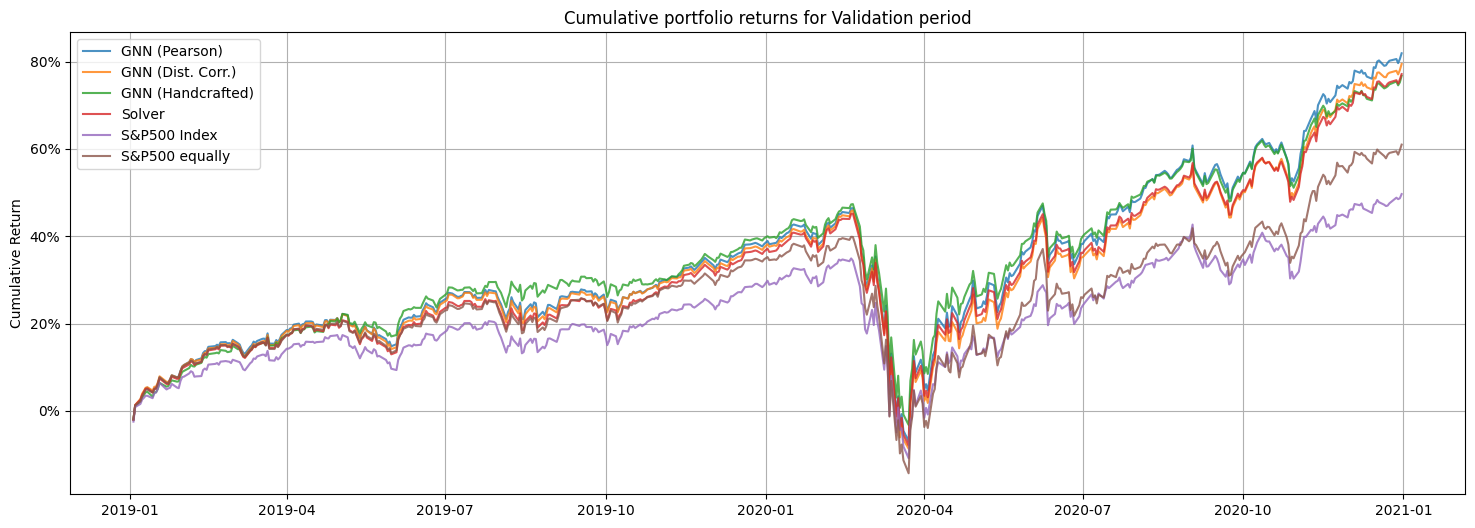

In [ ]:
# GNN Pearson Portfolio
print(f"# stocks in pearson portfolio: {len(gnn_mis_set_pearson)}")
gnn_mis_pearson_returns_val, gnn_mis_pearson_returns_cum_val = portfolio_return(
    df=df_val,
    assets=gnn_mis_set_pearson
)

# GNN DCOR Portfolio
print(f"# stocks in dist. corr. portfolio: {len(gnn_mis_set_dcor)}")
gnn_mis_dcor_returns_val, gnn_mis_dcor_returns_cum_val = portfolio_return(
    df=df_val,
    assets=gnn_mis_set_dcor
)

# GNN Handcrafted Portfolio
print(f"# stocks in handcrafted portfolio: {len(gnn_mis_set_handcrafted)}")
gnn_mis_handcrafted_returns_val, gnn_mis_handcrafted_returns_cum_val = portfolio_return(
    df=df_val,
    assets=gnn_mis_set_handcrafted
)

# Solver MIS Portfolio
print(f"# stocks in solver portfolio: {len(solver_mis_set)}")
solver_mis_returns_val, solver_mis_returns_cum_val = portfolio_return(
    df=df_val,
    assets=solver_mis_set
)

# Benchmark S&P500
gspc_returns_val = gspc_val.pct_change()
gspc_returns_cum_val = (gspc_returns_val + 1).cumprod() -1

# Benchmark all assets equally
gspc_equal_returns_val, gspc_equal_returns_cum_val = portfolio_return(
    df=df_val,
    assets=df_val.columns.to_list()
)

# Plot
alpha_value = 0.8
_, ax = plt.subplots(figsize=(18,6))

ax.plot(gnn_mis_pearson_returns_cum_val, label="GNN (Pearson)", alpha=alpha_value)
ax.plot(gnn_mis_dcor_returns_cum_val, label="GNN (DCOR)", alpha=alpha_value)
ax.plot(gnn_mis_handcrafted_returns_cum_val, label="GNN (Handcrafted)", alpha=alpha_value)
ax.plot(solver_mis_returns_cum_val, label="Solver", alpha=alpha_value)

ax.plot(gspc_returns_cum_val, label="S&P500 Index", alpha=alpha_value)
ax.plot(gspc_equal_returns_cum_val, label="S&P500 equally", alpha=alpha_value)

ax.set_title("Cumulative portfolio returns for Validation period")
ax.set_ylabel("Cumulative Return")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.legend()
ax.grid()
plt.show()

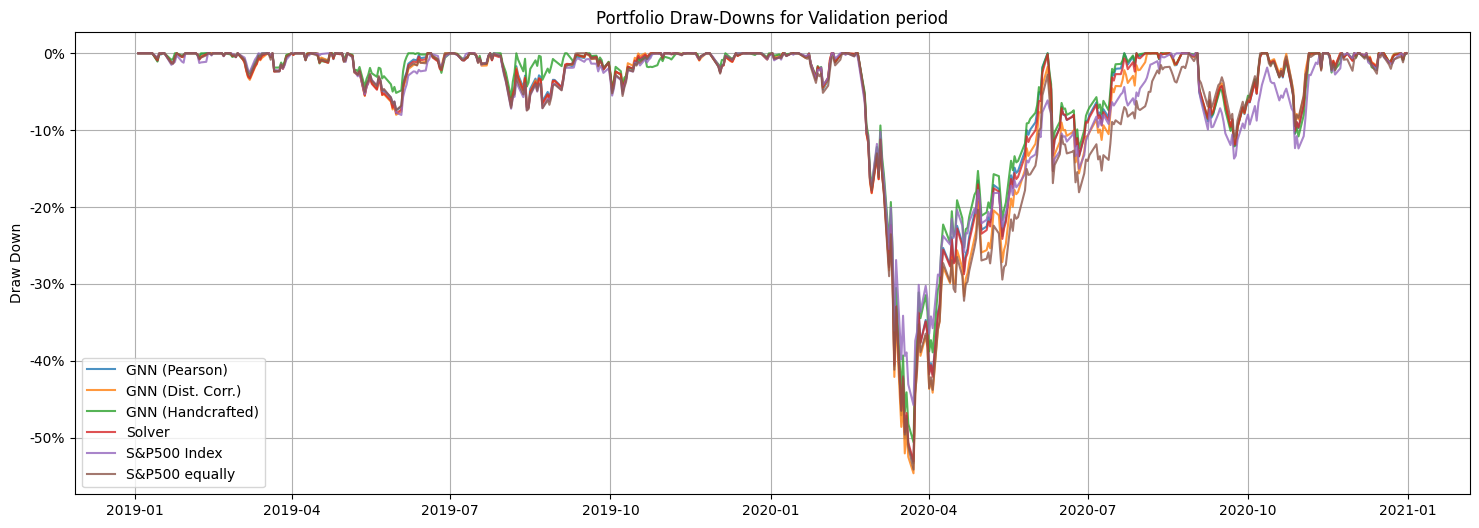

In [ ]:
gnn_mis_pearson_mdd_val = drawdown_pct(gnn_mis_pearson_returns_cum_val)
gnn_mis_dcor_mdd_val = drawdown_pct(gnn_mis_dcor_returns_cum_val)
gnn_mis_handcrafted_mdd_val = drawdown_pct(gnn_mis_handcrafted_returns_cum_val)
solver_mis_mdd_val = drawdown_pct(solver_mis_returns_cum_val)

gspc_mdd_val = drawdown_pct(gspc_returns_cum_val)
gspc_equal_mdd_val = drawdown_pct(gspc_equal_returns_cum_val)

# Plot
alpha_value = 0.8
_, ax = plt.subplots(figsize=(18,6))

ax.plot(gnn_mis_pearson_mdd_val, label="GNN (Pearson)", alpha=alpha_value)
ax.plot(gnn_mis_dcor_mdd_val, label="GNN (Dist. Corr.)", alpha=alpha_value)
ax.plot(gnn_mis_handcrafted_mdd_val, label="GNN (Handcrafted)", alpha=alpha_value)
ax.plot(solver_mis_mdd_val, label="Solver", alpha=alpha_value)

ax.plot(gspc_mdd_val, label="S&P500 Index", alpha=alpha_value)
ax.plot(gspc_equal_mdd_val, label="S&P500 equally", alpha=alpha_value)

ax.set_title("Portfolio Draw-Downs for Validation period")
ax.set_ylabel("Draw Down")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.legend()
ax.grid()
plt.show()

In [ ]:
# Sharpe Ratios
df_sharpe_val = pd.concat([
    annualized_sharpe_ratio(df_returns=gnn_mis_pearson_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_dcor_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (DCOR)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_handcrafted_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_sharpe_ratio(df_returns=solver_mis_returns_val, risk_free_rate=RISK_FREE_RATE, name='Solver'),
    annualized_sharpe_ratio(df_returns=gspc_returns_val, risk_free_rate=RISK_FREE_RATE, name='S&P500 Index'),
    annualized_sharpe_ratio(df_returns=gspc_equal_returns_val, risk_free_rate=RISK_FREE_RATE, name='S&P500 equally')
], axis=1).T

df_sharpe_val['Avg'] = df_sharpe_val.mean(axis=1)
df_sharpe_val.columns.rename('', inplace=True)
multi_idx = np.array([['Sharpe']*len(df_sharpe_val.index), df_sharpe_val.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sharpe_val.index = multi_idx
df_sharpe_val.round(2)

2019  2020   Avg
Metric Portfolio                          
Sharpe GNN (Pearson)      2.53  0.93  1.73
       GNN (Dist. Corr.)  2.46  0.89  1.67
       GNN (Handcrafted)  2.83  0.84  1.83
       Solver             2.41  0.89  1.65
       S&P500 Index       2.01  0.58  1.29
       S&P500 equally     2.37  0.63  1.50

In [ ]:
# Sortino Ratios
df_sortino_val = pd.concat([
    annualized_sortino_ratio(df_returns=gnn_mis_pearson_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    annualized_sortino_ratio(df_returns=gnn_mis_dcor_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (DCOR)'),
    annualized_sortino_ratio(df_returns=gnn_mis_handcrafted_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_sortino_ratio(df_returns=solver_mis_returns_val, risk_free_rate=RISK_FREE_RATE, name='Solver'),
    annualized_sortino_ratio(df_returns=gspc_returns_val, risk_free_rate=RISK_FREE_RATE, name='S&P500 Index'),
    annualized_sortino_ratio(df_returns=gspc_equal_returns_val, risk_free_rate=RISK_FREE_RATE, name='S&P500 Equal'),

], axis=1).T

df_sortino_val['Avg'] = df_sortino_val.mean(axis=1)
df_sortino_val.columns.rename('', inplace=True)
multi_idx = np.array([['Sortino']*len(df_sortino_val.index), df_sortino_val.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sortino_val.index = multi_idx
df_sortino_val.round(2)

2019  2020   Avg
Metric  Portfolio                          
Sortino GNN (Pearson)      3.25  1.02  2.14
        GNN (Dist. Corr.)  3.19  0.99  2.09
        GNN (Handcrafted)  3.65  0.92  2.29
        Solver             3.11  0.99  2.05
        S&P500 Index       2.48  0.66  1.57
        S&P500 Equal       3.01  0.73  1.87

In [ ]:
# Maximal Draw Down
df_mdd_val = pd.concat([
    annualized_max_drawdown(df_returns=gnn_mis_pearson_returns_val, name='GNN (Pearson)'),
    annualized_max_drawdown(df_returns=gnn_mis_dcor_returns_val, name='GNN (DCOR)'),
    annualized_max_drawdown(df_returns=gnn_mis_handcrafted_returns_val, name='GNN (Handcrafted)'),
    annualized_max_drawdown(df_returns=solver_mis_returns_val, name='Solver'),
    annualized_max_drawdown(df_returns=gspc_returns_val, name='S&P500 Index'),
    annualized_max_drawdown(df_returns=gspc_equal_returns_val, name='S&P500 Equal')

], axis=1).T

df_mdd_val['Avg'] = df_mdd_val.mean(axis=1)
df_mdd_val.columns.rename('', inplace=True)
multi_idx = np.array([['MDD']*len(df_mdd_val.index), df_mdd_val.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_mdd_val.index = multi_idx
df_mdd_val.round(2)

2019  2020   Avg
Metric Portfolio                          
MDD    GNN (Pearson)     -0.07 -0.53 -0.30
       GNN (Dist. Corr.) -0.08 -0.55 -0.31
       GNN (Handcrafted) -0.06 -0.51 -0.28
       Solver            -0.08 -0.53 -0.30
       S&P500 Index      -0.08 -0.46 -0.27
       S&P500 Equal      -0.07 -0.54 -0.31

In [ ]:
# Calmar Ratios
df_calmar_val = pd.concat([
    annualized_calmar_ratio(df_returns=gnn_mis_pearson_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    annualized_calmar_ratio(df_returns=gnn_mis_dcor_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (DCOR)'),
    annualized_calmar_ratio(df_returns=gnn_mis_handcrafted_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_calmar_ratio(df_returns=solver_mis_returns_val, risk_free_rate=RISK_FREE_RATE, name='Solver'),
    annualized_calmar_ratio(df_returns=gspc_returns_val, risk_free_rate=RISK_FREE_RATE, name='S&P500'),
    annualized_calmar_ratio(df_returns=gspc_equal_returns_val, risk_free_rate=RISK_FREE_RATE, name='S&P500 Equal'),

], axis=1).T

df_calmar_val['Avg'] = df_calmar_val.mean(axis=1)
df_calmar_val.columns.rename('', inplace=True)
multi_idx = np.array([['Calmar']*len(df_calmar_val.index), df_calmar_val.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_calmar_val.index = multi_idx
df_calmar_val.round(2)

2019  2020   Avg
Metric Portfolio                          
Calmar GNN (Pearson)      4.33  0.62  2.47
       GNN (Dist. Corr.)  3.95  0.59  2.27
       GNN (Handcrafted)  5.71  0.56  3.14
       Solver             3.96  0.59  2.28
       S&P500             3.12  0.44  1.78
       S&P500 Equal       3.97  0.45  2.21

### Test

# stocks in pearson portfolio: 196
# stocks in dist. corr. portfolio: 168
# stocks in handcrafted portfolio: 139
# stocks in solver portfolio: 194


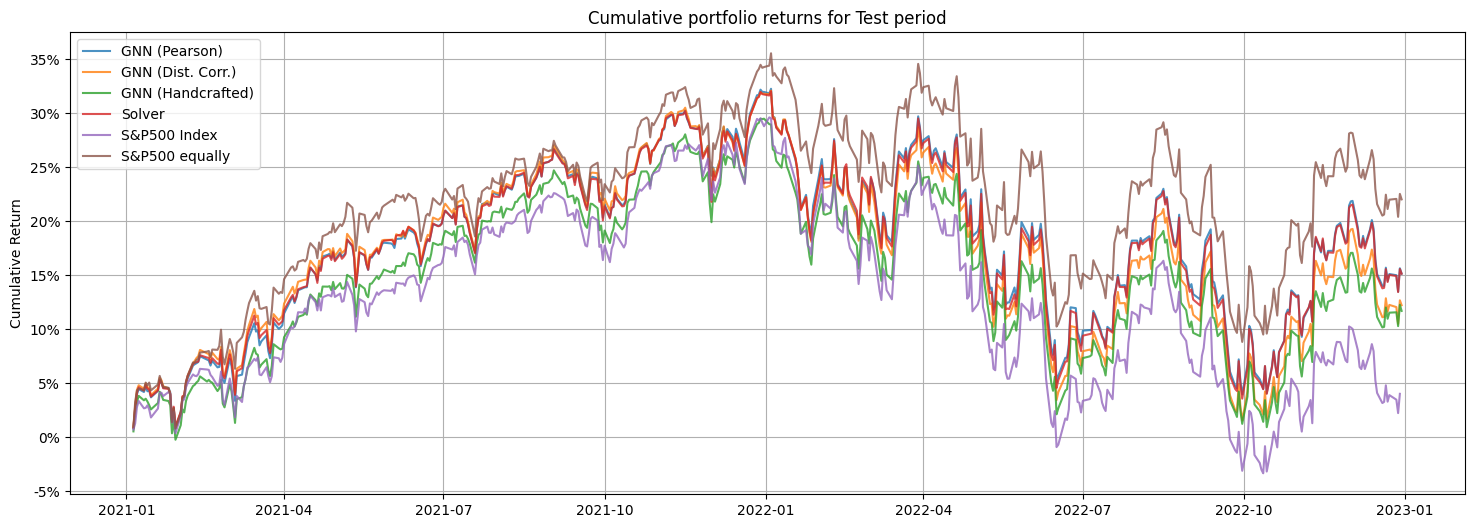

In [ ]:
# GNN Pearson Portfolio
print(f"# stocks in pearson portfolio: {len(gnn_mis_set_pearson)}")
gnn_mis_pearson_returns_test, gnn_mis_pearson_returns_cum_test = portfolio_return(
    df=df_test,
    assets=gnn_mis_set_pearson
)

# GNN DCOR Portfolio
print(f"# stocks in dist. corr. portfolio: {len(gnn_mis_set_dcor)}")
gnn_mis_dcor_returns_test, gnn_mis_dcor_returns_cum_test = portfolio_return(
    df=df_test,
    assets=gnn_mis_set_dcor
)

# GNN Handcrafted Portfolio
print(f"# stocks in handcrafted portfolio: {len(gnn_mis_set_handcrafted)}")
gnn_mis_handcrafted_returns_test, gnn_mis_handcrafted_returns_cum_test = portfolio_return(
    df=df_test,
    assets=gnn_mis_set_handcrafted
)

# Solver MIS Portfolio
print(f"# stocks in solver portfolio: {len(solver_mis_set)}")
solver_mis_returns_test, solver_mis_returns_cum_test = portfolio_return(
    df=df_test,
    assets=solver_mis_set
)

# Benchmark S&P500
gspc_returns_test = gspc_test.pct_change()
gspc_returns_cum_test = (gspc_returns_test + 1).cumprod() -1

# Benchmark all assets equally
gspc_equal_returns_test, gspc_equal_returns_cum_test = portfolio_return(
    df=df_test,
    assets=df_test.columns.to_list()
)

# Plot
alpha_value = 0.8
_, ax = plt.subplots(figsize=(18,6))

ax.plot(gnn_mis_pearson_returns_cum_test, label="GNN (Pearson)", alpha=alpha_value)
ax.plot(gnn_mis_dcor_returns_cum_test, label="GNN (DCOR)", alpha=alpha_value)
ax.plot(gnn_mis_handcrafted_returns_cum_test, label="GNN (Handcrafted)", alpha=alpha_value)
ax.plot(solver_mis_returns_cum_test, label="Solver", alpha=alpha_value)

ax.plot(gspc_returns_cum_test, label="S&P500 Index", alpha=alpha_value)
ax.plot(gspc_equal_returns_cum_test, label="S&P500 equally", alpha=alpha_value)

ax.set_title("Cumulative portfolio returns for Test period")
ax.set_ylabel("Cumulative Return")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.legend()
ax.grid()
plt.show()

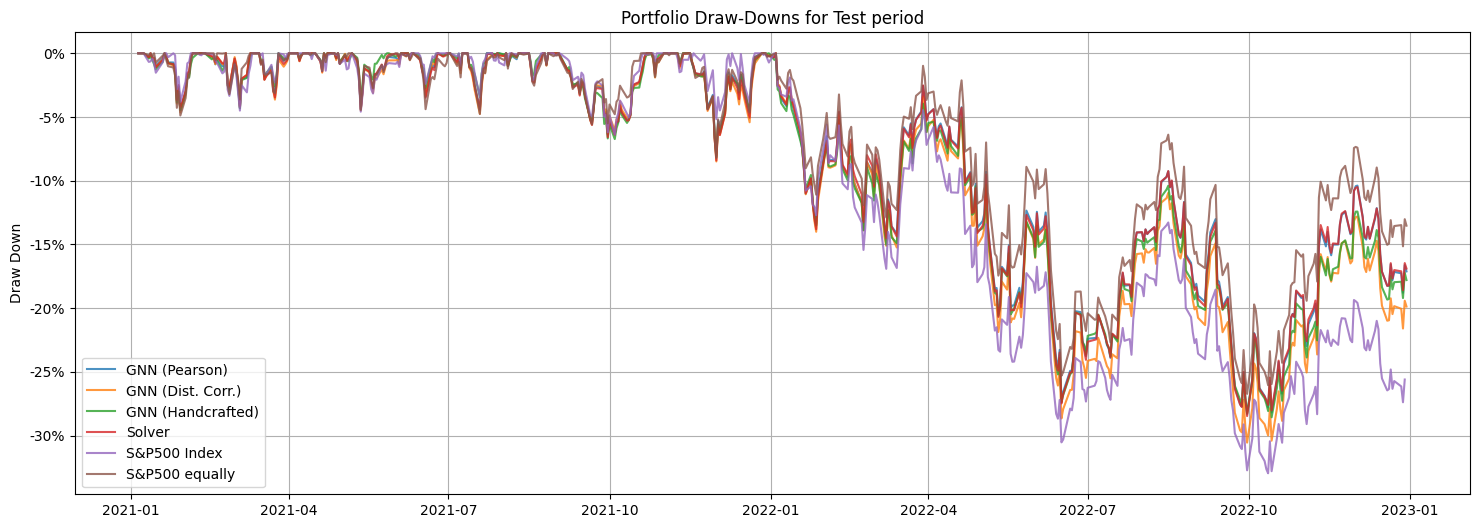

In [ ]:
gnn_mis_pearson_mdd_test = drawdown_pct(gnn_mis_pearson_returns_cum_test)
gnn_mis_dcor_mdd_test = drawdown_pct(gnn_mis_dcor_returns_cum_test)
gnn_mis_handcrafted_mdd_test = drawdown_pct(gnn_mis_handcrafted_returns_cum_test)
solver_mis_mdd_test = drawdown_pct(solver_mis_returns_cum_test)

gspc_mdd_test = drawdown_pct(gspc_returns_cum_test)
gspc_equal_mdd_test = drawdown_pct(gspc_equal_returns_cum_test)

# Plot
alpha_value = 0.8
_, ax = plt.subplots(figsize=(18,6))

ax.plot(gnn_mis_pearson_mdd_test, label="GNN (Pearson)", alpha=alpha_value)
ax.plot(gnn_mis_dcor_mdd_test, label="GNN (DCOR)", alpha=alpha_value)
ax.plot(gnn_mis_handcrafted_mdd_test, label="GNN (Handcrafted)", alpha=alpha_value)
ax.plot(solver_mis_mdd_test, label="Solver", alpha=alpha_value)

ax.plot(gspc_mdd_test, label="S&P500 Index", alpha=alpha_value)
ax.plot(gspc_equal_mdd_test, label="S&P500 equally", alpha=alpha_value)

ax.set_title("Portfolio Draw-Downs for Test period")
ax.set_ylabel("Draw Down")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.legend()
ax.grid()
plt.show()

In [ ]:
# Sharpe Ratios
df_sharpe_test = pd.concat([
    annualized_sharpe_ratio(df_returns=gnn_mis_pearson_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_dcor_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (DCOR)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_handcrafted_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_sharpe_ratio(df_returns=solver_mis_returns_test, risk_free_rate=RISK_FREE_RATE, name='Solver'),
    annualized_sharpe_ratio(df_returns=gspc_returns_test, risk_free_rate=RISK_FREE_RATE, name='S&P500 Index'),
    annualized_sharpe_ratio(df_returns=gspc_equal_returns_test, risk_free_rate=RISK_FREE_RATE, name='S&P500 equally')
], axis=1).T

df_sharpe_test['Avg'] = df_sharpe_test.mean(axis=1)
df_sharpe_test.columns.rename('', inplace=True)
multi_idx = np.array([['Sharpe']*len(df_sharpe_test.index), df_sharpe_test.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sharpe_test.index = multi_idx
df_sharpe_test.round(2)

2021  2022   Avg
Metric Portfolio                          
Sharpe GNN (Pearson)      2.10 -0.49  0.80
       GNN (Dist. Corr.)  2.03 -0.58  0.73
       GNN (Handcrafted)  2.09 -0.57  0.76
       Solver             2.08 -0.48  0.80
       S&P500 Index       1.93 -0.81  0.56
       S&P500 equally     2.17 -0.35  0.91

In [ ]:
# Sortino Ratios
df_sortino_test = pd.concat([
    annualized_sortino_ratio(df_returns=gnn_mis_pearson_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    annualized_sortino_ratio(df_returns=gnn_mis_dcor_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (DCOR)'),
    annualized_sortino_ratio(df_returns=gnn_mis_handcrafted_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_sortino_ratio(df_returns=solver_mis_returns_test, risk_free_rate=RISK_FREE_RATE, name='Solver'),
    annualized_sortino_ratio(df_returns=gspc_returns_test, risk_free_rate=RISK_FREE_RATE, name='S&P500 Index'),
    annualized_sortino_ratio(df_returns=gspc_equal_returns_test, risk_free_rate=RISK_FREE_RATE, name='S&P500 Equal'),
], axis=1).T

df_sortino_test['Avg'] = df_sortino_test.mean(axis=1)
df_sortino_test.columns.rename('', inplace=True)
multi_idx = np.array([['Sortino']*len(df_sortino_test.index), df_sortino_test.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sortino_test.index = multi_idx
df_sortino_test.round(2)

2021  2022   Avg
Metric  Portfolio                          
Sortino GNN (Pearson)      3.05 -0.82  1.11
        GNN (Dist. Corr.)  3.00 -0.95  1.02
        GNN (Handcrafted)  2.95 -0.96  0.99
        Solver             3.03 -0.79  1.12
        S&P500 Index       2.75 -1.29  0.73
        S&P500 Equal       3.15 -0.57  1.29

In [ ]:
# Maximal Draw Down
df_mdd_test = pd.concat([
    annualized_max_drawdown(df_returns=gnn_mis_pearson_returns_test, name='GNN (Pearson)'),
    annualized_max_drawdown(df_returns=gnn_mis_dcor_returns_test, name='GNN (DCOR)'),
    annualized_max_drawdown(df_returns=gnn_mis_handcrafted_returns_test, name='GNN (Handcrafted)'),
    annualized_max_drawdown(df_returns=solver_mis_returns_test, name='Solver'),
    annualized_max_drawdown(df_returns=gspc_returns_test, name='S&P500 Index'),
    annualized_max_drawdown(df_returns=gspc_equal_returns_test, name='S&P500 Equal')
], axis=1).T

df_mdd_test['Avg'] = df_mdd_test.mean(axis=1)
df_mdd_test.columns.rename('', inplace=True)
multi_idx = np.array([['MDD']*len(df_mdd_test.index), df_mdd_test.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_mdd_test.index = multi_idx
df_mdd_test.round(2)

2021  2022   Avg
Metric Portfolio                          
MDD    GNN (Pearson)     -0.08 -0.28 -0.18
       GNN (Dist. Corr.) -0.08 -0.31 -0.20
       GNN (Handcrafted) -0.08 -0.29 -0.18
       Solver            -0.08 -0.28 -0.18
       S&P500 Index      -0.06 -0.33 -0.20
       S&P500 Equal      -0.08 -0.27 -0.17

In [ ]:
# Calmar Ratios
df_calmar_test = pd.concat([
    annualized_calmar_ratio(df_returns=gnn_mis_pearson_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    annualized_calmar_ratio(df_returns=gnn_mis_dcor_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (DCOR)'),
    annualized_calmar_ratio(df_returns=gnn_mis_handcrafted_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_calmar_ratio(df_returns=solver_mis_returns_test, risk_free_rate=RISK_FREE_RATE, name='Solver'),
    annualized_calmar_ratio(df_returns=gspc_returns_test, risk_free_rate=RISK_FREE_RATE, name='S&P500'),
    annualized_calmar_ratio(df_returns=gspc_equal_returns_test, risk_free_rate=RISK_FREE_RATE, name='S&P500 Equal'),
], axis=1).T

df_calmar_test['Avg'] = df_calmar_test.mean(axis=1)
df_calmar_test.columns.rename('', inplace=True)
multi_idx = np.array([['Calmar']*len(df_calmar_test.index), df_calmar_test.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_calmar_test.index = multi_idx
df_calmar_test.round(2)

2021  2022   Avg
Metric Portfolio                          
Calmar GNN (Pearson)      3.44 -0.42  1.51
       GNN (Dist. Corr.)  3.24 -0.46  1.39
       GNN (Handcrafted)  3.15 -0.46  1.34
       Solver             3.26 -0.41  1.43
       S&P500             3.94 -0.59  1.67
       S&P500 Equal       3.58 -0.30  1.64